Final Machine Learing - Dự đoán giá nhà

Trần Trung Hiếu - 52000888,
Nguyễn Tiến Dũng - 52000883,
Trần Quang Luân - 52100254

Thư viện

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import time

Xem thông tin

In [ ]:
# Đọc dữ liệu từ file CSV
data = pd.read_csv('data_newv2.csv')
data.dropna()
data.drop_duplicates()
data.head(5)

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661.0,1.0,8.0,10.0,3.0,82.6,10.8,1.0
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81.0,3.0,5.0,24.0,2.0,69.1,12.0,1.0
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871.0,1.0,5.0,9.0,3.0,66.0,10.0,1.0
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843.0,4.0,12.0,16.0,2.0,38.0,5.0,11.0
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81.0,3.0,13.0,14.0,2.0,60.0,10.0,1.0


Tiền xử lý dữ liệu

In [ ]:
# Chia thuộc tính "date" thành ngày, tháng và năm
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['year'] = data['date'].dt.year

# Xóa cột "date" gốc
data = data.drop('date', axis=1)

# Chia thuộc tính "time" thành giờ, phút và giây
data['hour'] = data['time'].str.split(':').str[0]
data['minute'] = data['time'].str.split(':').str[1]
data['second'] = data['time'].str.split(':').str[2]

# Chuyển đổi giờ, phút và giây thành kiểu số nguyên
data['hour'] = data['hour'].astype(int)
data['minute'] = data['minute'].astype(int)
data['second'] = data['second'].astype(int)

# Xóa cột "time" gốc
data = data.drop('time', axis=1)

In [ ]:
data.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264693 entries, 0 to 264692
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   price          264693 non-null  int64  
 1   geo_lat        264693 non-null  float64
 2   geo_lon        264693 non-null  float64
 3   region         264692 non-null  float64
 4   building_type  264692 non-null  float64
 5   level          264692 non-null  float64
 6   levels         264692 non-null  float64
 7   rooms          264692 non-null  float64
 8   area           264692 non-null  float64
 9   kitchen_area   264692 non-null  float64
 10  object_type    264692 non-null  float64
 11  month          264693 non-null  int64  
 12  day            264693 non-null  int64  
 13  year           264693 non-null  int64  
 14  hour           264693 non-null  int64  
 15  minute         264693 non-null  int64  
 16  second         264693 non-null  int64  
dtypes: float64(10), int64(7)
memo

In [ ]:
data.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,month,day,year,hour,minute,second
count,2.646930e+05,264693.000000,264693.000000,264692.000000,264692.000000,264692.000000,264692.000000,264692.000000,264692.000000,264692.000000,264692.000000,264693.000000,264693.000000,264693.0,264693.000000,264693.000000,264693.000000
mean,3.975681e+06,54.045621,54.839746,4627.879558,1.852070,6.094359,11.167077,1.799609,53.982628,10.554366,3.962273,9.329706,15.180386,2018.0,10.825749,29.794989,29.341781
std,1.445156e+07,4.664777,21.166659,3536.975532,1.087922,4.806065,6.220018,0.925814,27.653591,8.308738,4.565933,0.482528,7.815419,0.0,5.659880,17.085632,17.459409
min,5.900000e+02,41.459089,27.638098,3.000000,0.000000,1.000000,1.000000,-1.000000,5.000000,0.040000,1.000000,2.000000,1.000000,2018.0,0.000000,0.000000,0.000000
25%,1.680000e+06,54.735745,37.904321,2661.000000,1.000000,2.000000,5.000000,1.000000,39.000000,7.000000,1.000000,9.000000,10.000000,2018.0,6.000000,15.000000,14.000000
50%,2.550000e+06,55.053036,43.953640,2922.000000,2.000000,5.000000,10.000000,2.000000,48.020000,9.560000,1.000000,9.000000,14.000000,2018.0,11.000000,31.000000,29.000000
75%,4.200000e+06,56.115758,82.949660,9654.000000,3.000000,8.000000,16.000000,2.000000,63.000000,12.400000,11.000000,10.000000,21.000000,2018.0,15.000000,44.000000,45.000000
max,1.680000e+09,71.636251,156.281145,14880.000000,5.000000,37.000000,39.000000,9.000000,3800.000000,1958.000000,11.000000,10.000000,31.000000,2018.0,23.000000,59.000000,59.000000


In [ ]:
data = data[data['price'] > 0]

In [ ]:
data['rooms'].unique()


array([ 3.,  2.,  1.,  4., -1.,  5.,  7.,  6.,  8.,  9., nan])

In [ ]:
data = data[data['rooms'] != -2]
data.loc[data['rooms'] == -1, 'rooms'] = 0

In [ ]:
data['object_type'].unique()

array([ 1., 11., nan])

In [ ]:
data.loc[data['object_type'] == 11, 'object_type'] = 2

In [ ]:
data = data[data.price.between(data.price.quantile(0.05), data.price.quantile(0.95))]
data = data[data.area.between(data.area.quantile(0.01), data.area.quantile(0.99))]

Chuyển tách x, y

In [ ]:
X = data[['month', 'day', 'year', 'hour', 'minute', 'second', 'geo_lat', 'geo_lon', 'region', 'building_type', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'object_type']]
y = data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Hàm trực quan hóa kết quả

In [ ]:
import random
def visualize(y_test,y_pred):
    random.seed(42)
    # sample_indices = random.sample(range(len(y_test)), 50000)
    # Lấy số lượng mẫu bằng hoặc ít hơn tổng số phần tử trong y_test
    sample_size = min(50000, len(y_test))
    sample_indices = random.sample(range(len(y_test)), sample_size)

    sample_y_test = y_test.iloc[sample_indices]
    sample_y_pred = y_pred[sample_indices]

    plt.figure(figsize=(10, 6))
    plt.scatter(sample_y_test, sample_y_pred, c='blue', label='Actual vs. Predicted', alpha=0.7)
    plt.plot([min(sample_y_test), max(sample_y_test)], [min(sample_y_test), max(sample_y_test)], 'k--', lw=2, label='Ideal Line')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted House Prices")
    plt.legend()
    plt.grid(True)
    plt.show()

Hàm đánh giá model

In [ ]:
def model_rp(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R2):", r2)
    print("Mean Absolute Error(MAE):", mae)
    visualize(y_test,y_pred)

models= []

In [ ]:
def corr_matrix(df: pd.DataFrame) -> pd.DataFrame:
    """
    Visualize correlation matrix
    :param df: Original DataFrame
    :return: corr DataFrame
    """
    corrmat = df.corr()
    fig, axes = plt.subplots(figsize=(15, 15))
    sns.heatmap(corrmat, annot=True, cmap="YlGnBu", linewidths=0.1, annot_kws={"fontsize":10})

    return corrmat

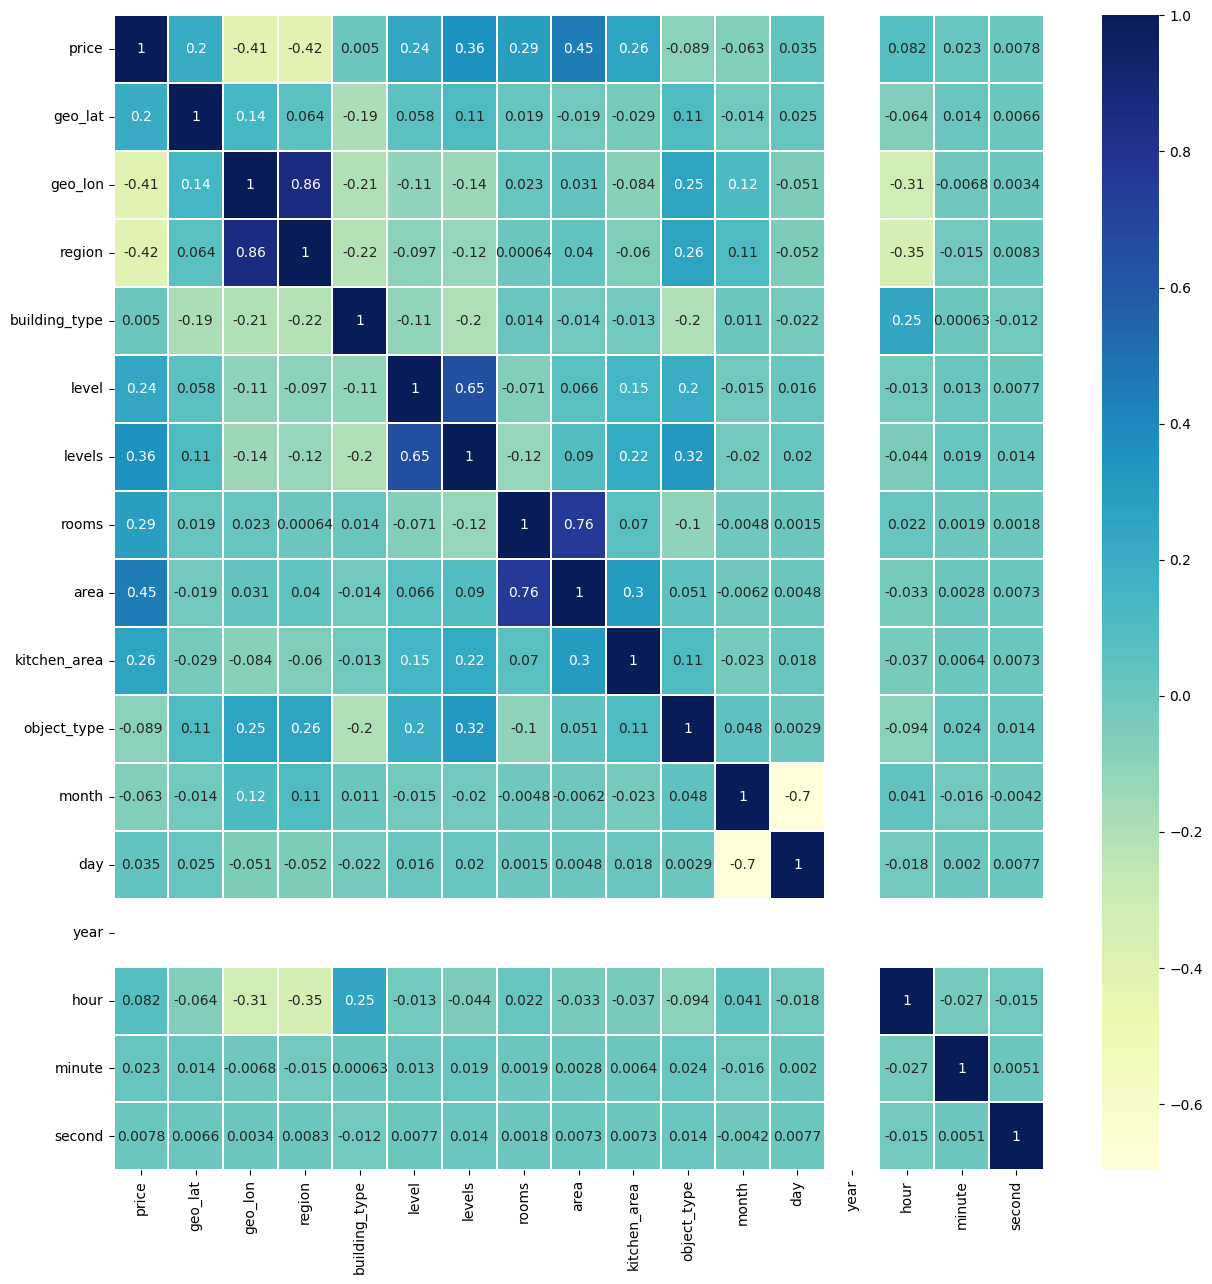

In [ ]:
corrmat = corr_matrix(data)

Linear Regresssion Model

Mean Squared Error (MSE): 1575459387735.5452
R-squared (R2): 0.5338451451872992
Mean Absolute Error(MAE): 935111.9103619097


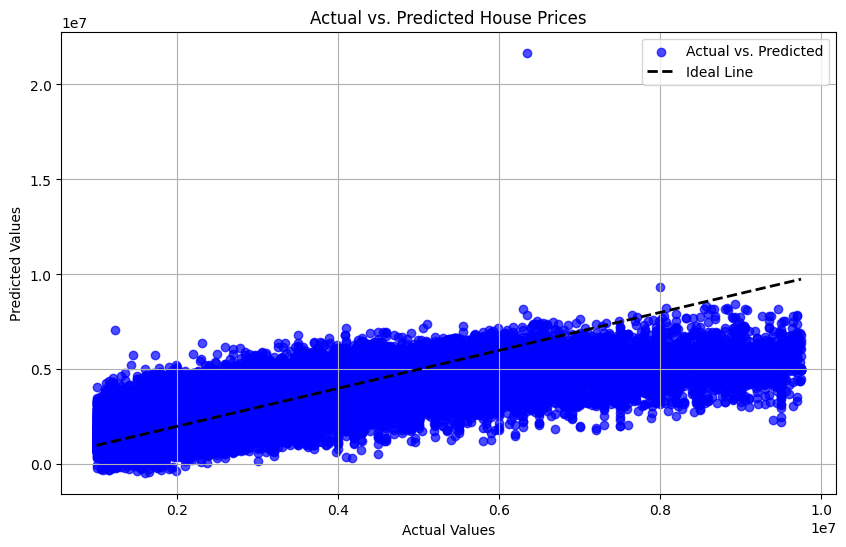

In [ ]:
LN_model = LinearRegression()
LN_model.fit(X_train_scaled, y_train)
LN_y_pred = LN_model.predict(X_test_scaled)
model_rp(y_test, LN_y_pred)

models.append(LN_model)

Decision Tree Regression Model

Mean Squared Error (MSE): 857716917954.5599
R-squared (R2): 0.7462144004015292
Mean Absolute Error(MAE): 639418.0979219591


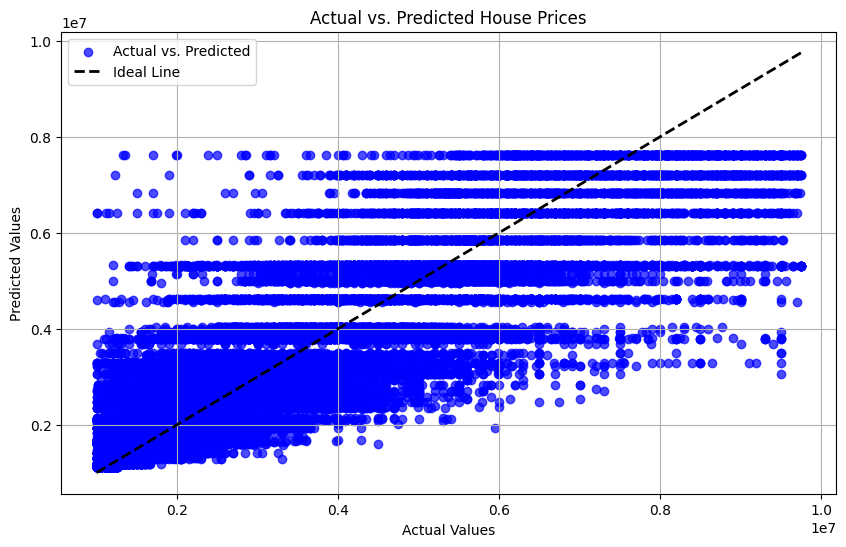

In [ ]:
DT_model = DecisionTreeRegressor(max_depth=15, min_samples_split=5000)
DT_model.fit(X_train_scaled, y_train)
DT_y_pred = DT_model.predict(X_test_scaled)
model_rp(y_test, DT_y_pred)

models.append(DT_model)

Huber Regression Model

Mean Squared Error (MSE): 1650864152608.7727
R-squared (R2): 0.511534003754331
Mean Absolute Error(MAE): 910630.1881422661


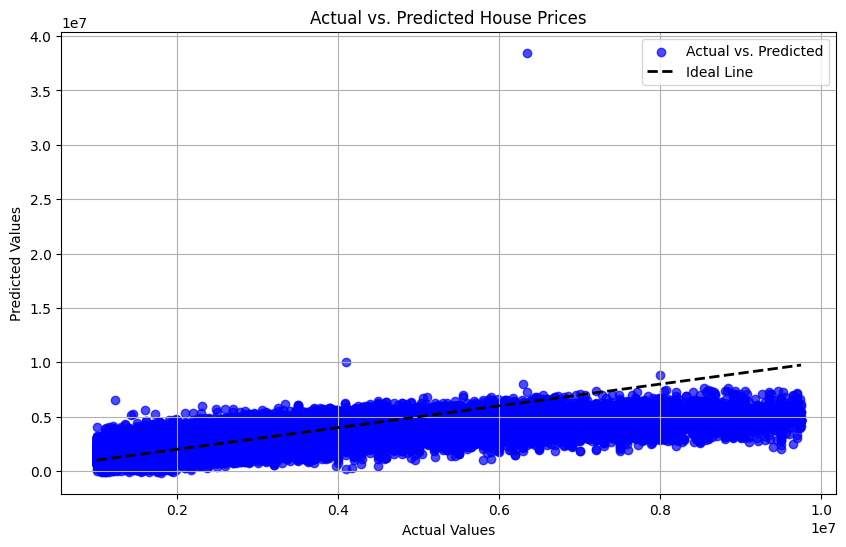

In [ ]:
huber_model = HuberRegressor(epsilon=1.35, alpha=0.001)
huber_model.fit(X_train_scaled, y_train)
huber_y_pred = huber_model.predict(X_test_scaled)
model_rp(y_test, huber_y_pred)

models.append(huber_model)

Elastic Net Model

Mean Squared Error (MSE): 1575579763672.4644
R-squared (R2): 0.5338095277490875
Mean Absolute Error(MAE): 934612.3684032771


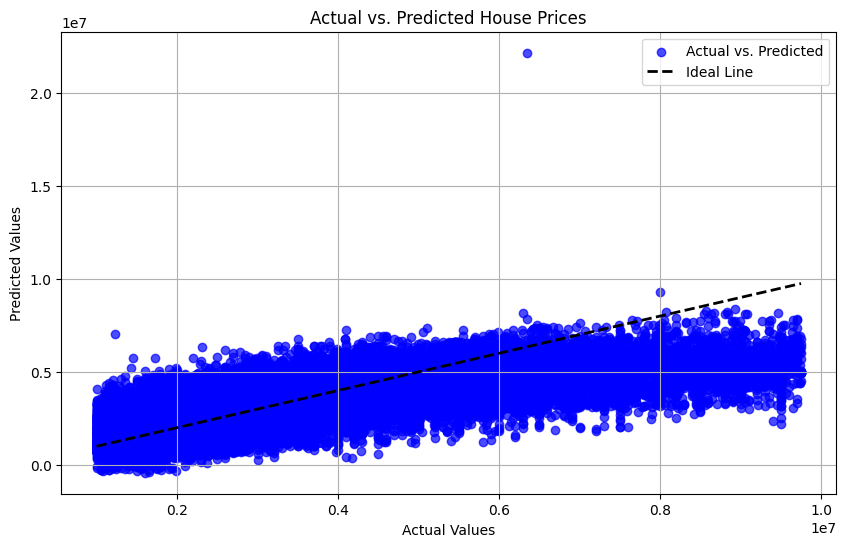

In [ ]:
elastic_net_model = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=32)
elastic_net_model.fit(X_train_scaled, y_train)
elastic_net_y_pred = elastic_net_model.predict(X_test_scaled)
model_rp(y_test, elastic_net_y_pred)

models.append(elastic_net_model)

Ridge Model

Mean Squared Error (MSE): 1575459428023.1462
R-squared (R2): 0.5338451332668009
Mean Absolute Error(MAE): 935111.3426396663


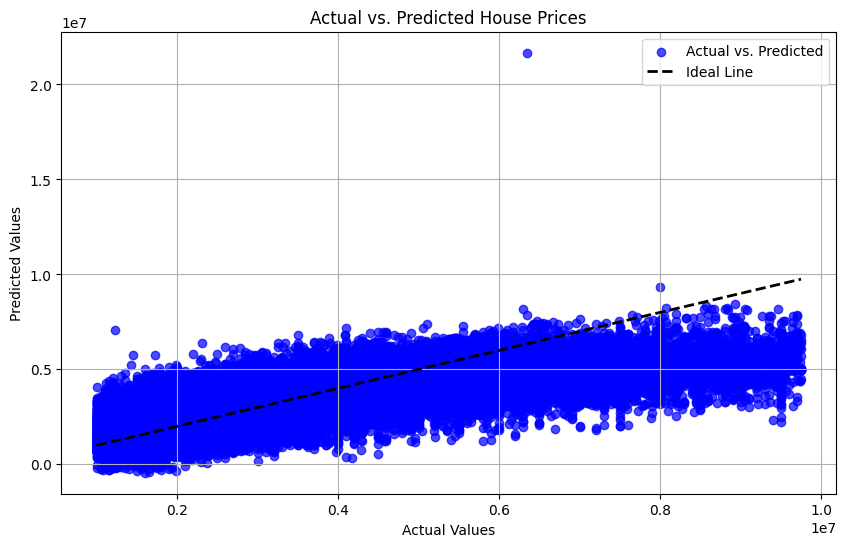

In [ ]:
ridge_model = Ridge(alpha=1.0, random_state=32)
ridge_model.fit(X_train_scaled, y_train)
ridge_y_pred = ridge_model.predict(X_test_scaled)
model_rp(y_test, ridge_y_pred)

models.append(ridge_model)

Gradient Boosting Regression Model

Mean Squared Error (MSE): 618189336998.7361
R-squared (R2): 0.8170870268832484
Mean Absolute Error(MAE): 551164.3137580738


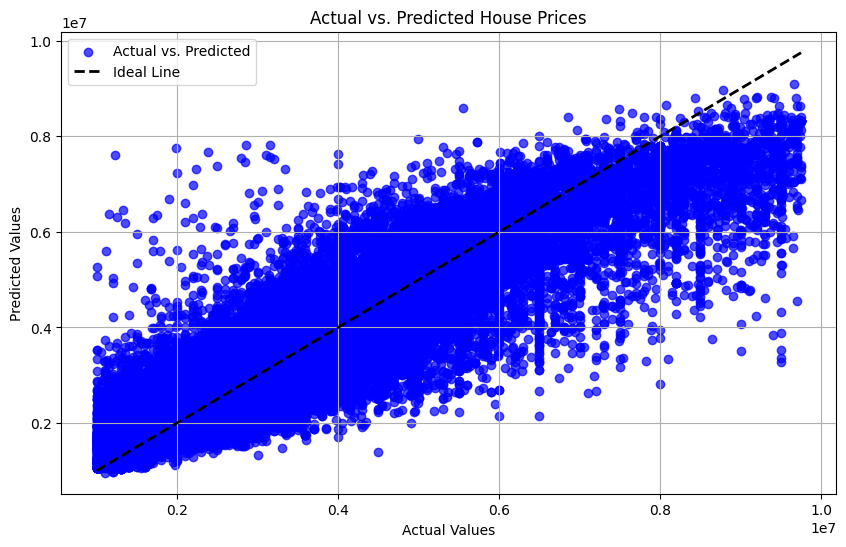

In [ ]:
GB_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
GB_model.fit(X_train_scaled, y_train)
GB_y_pred = GB_model.predict(X_test_scaled)
model_rp(y_test, GB_y_pred)

models.append(GB_model)

Random Forest Regression Model

Mean Squared Error (MSE): 829711001399.5438
R-squared (R2): 0.7545009319790676
Mean Absolute Error(MAE): 648246.5743479436


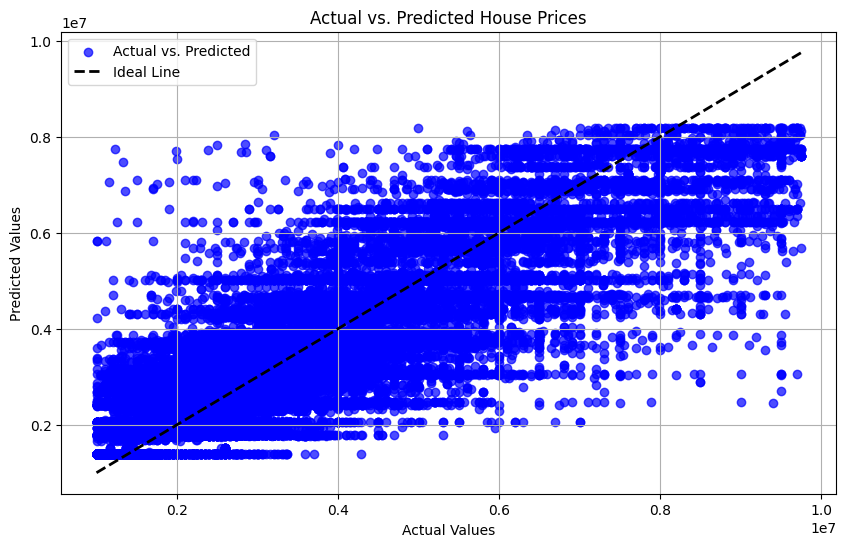

In [ ]:
RF_model = RandomForestRegressor(n_estimators=25, max_depth=6, random_state=32)
RF_model.fit(X_train_scaled, y_train)
RF_y_pred = RF_model.predict(X_test_scaled)
model_rp(y_test, RF_y_pred)

models.append(RF_model)

Multi-Layer Perceptron Model

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Mean Squared Error (MSE): 1200644520165.2688
R-squared (R2): 0.6447472550950617
Mean Absolute Error(MAE): 773316.8234352538


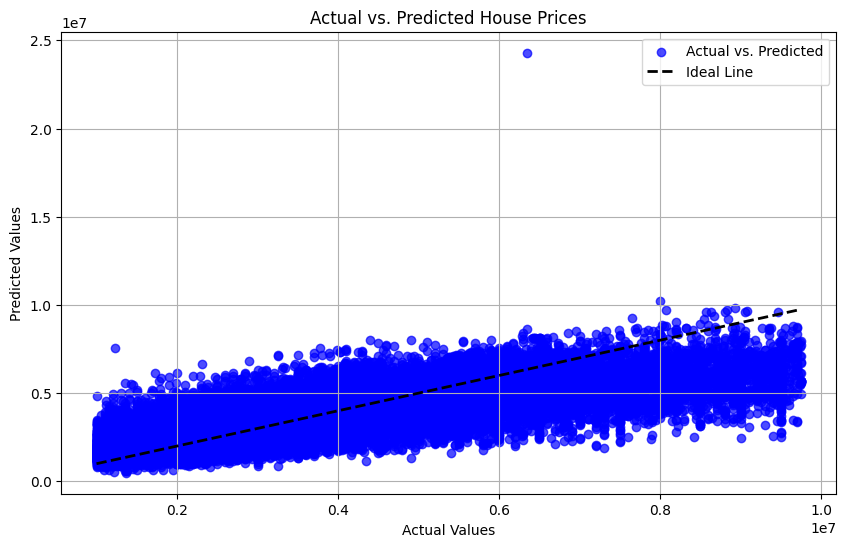

In [ ]:
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)
model_rp(y_test, y_pred_mlp)

models.append(mlp_model)

Long - Short Term Memory Model

Epoch 1/50
4696/4696 [==============================] - 67s 14ms/step - loss: 4803171713024.0000 - val_loss: 3340622626816.0000
Epoch 2/50
4696/4696 [==============================] - 65s 14ms/step - loss: 3417230016512.0000 - val_loss: 3497738371072.0000
Epoch 3/50
4696/4696 [==============================] - 71s 15ms/step - loss: 3211868241920.0000 - val_loss: 2809695567872.0000
Epoch 4/50
4696/4696 [==============================] - 70s 15ms/step - loss: 2452733296640.0000 - val_loss: 2243505160192.0000
Epoch 5/50
4696/4696 [==============================] - 65s 14ms/step - loss: 2327860740096.0000 - val_loss: 2189432717312.0000
Epoch 6/50
4696/4696 [==============================] - 70s 15ms/step - loss: 2302113218560.0000 - val_loss: 2464842252288.0000
Epoch 7/50
4696/4696 [==============================] - 66s 14ms/step - loss: 2273417101312.0000 - val_loss: 2286806630400.0000
Epoch 8/50
4696/4696 [==============================] - 65s 14ms/step - loss: 2231473012736.0000 - val_l

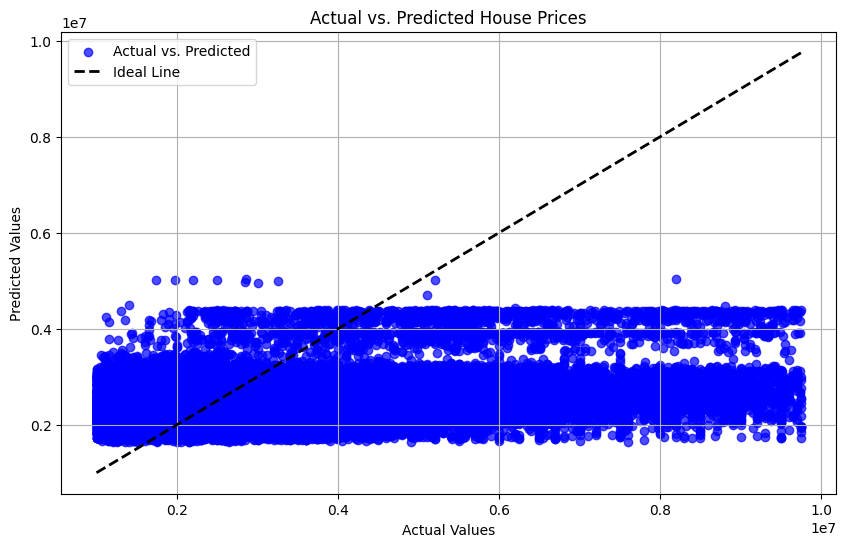

In [50]:

# Trước khi đưa vào mô hình, reshape dữ liệu thành (batch_size, timesteps, features)
X_train_scaled_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Mô hình LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2]), activation='relu'))
model_lstm.add(Dropout(0.2))  # Thêm dropout để tăng tính linh hoạt
model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(Dense(1))  # 1 neuron để dự đoán giá trị tiếp theo
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model_lstm.fit(X_train_scaled_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Dự đoán và đánh giá
y_pred_lstm = model_lstm.predict(X_test_scaled_reshaped)
model_rp(y_test, y_pred_lstm)

models.append(model_lstm)

Dự đoán giá nhà cho một căn nhà mới

In [51]:
# New house data
new_house = [[2, 19, 2018, 20, 20, 21, 59.8058084, 30.376141, 2661, 1, 8, 10, 3, 82.6, 10.8, 1]]

# Scale the new house data using the same scaler
new_house_scaled = scaler.transform(new_house)

# Predict the price for the new house
new_price = GB_model.predict(new_house_scaled)

print(f"Predicted price for the new house: {new_price}")

Predicted price for the new house: [6626271.96213868]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
